In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader

import torchvision
import torchvision.transforms as transforms
from torchsummary import summary

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('DEVICE:',device)
print('USE CUDA:',torch.cuda.is_available())

DEVICE: cpu
USE CUDA: False


In [3]:
trans = transforms.Compose([transforms.ToTensor(),
                            transforms.Normalize((0.5),(0.5))
                            ])

In [4]:
train_dataset = torchvision.datasets.FashionMNIST(root=r'C:\Users\Administrator\Desktop\Dataset',
                                                  download=True,
                                                  transform=trans,
                                                  train=True)
val_dataset = torchvision.datasets.FashionMNIST(root=r'C:\Users\Administrator\Desktop\Dataset',
                                                 download=True,
                                                 transform=trans,
                                                 train=False)

In [5]:
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=128,
                          shuffle=True,
                          drop_last=True)
val_loader = DataLoader(dataset=val_dataset,
                          batch_size=len(val_dataset))


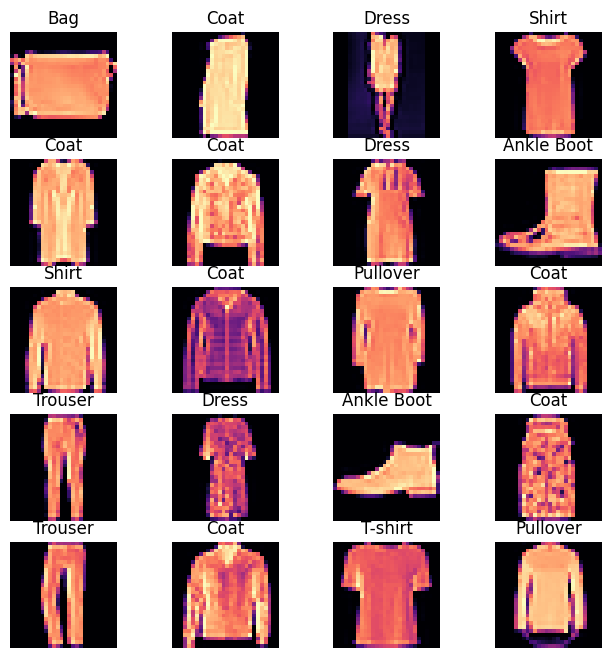

In [6]:
label_dict = {0:'T-shirt',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',
              6:'Shirt',7:'Sneaker',8:'Bag',9:'Ankle Boot'}

fig = plt.figure(figsize=(8,8))

columns = 4
rows = 5

for i in range(1,columns*rows+1):
    img_xy = np.random.randint(len(train_dataset))
    img = train_dataset[img_xy][0][0]
    fig.add_subplot(rows,columns,i)
    plt.title(label_dict[train_dataset[img_xy][1]])
    plt.axis('off')
    plt.imshow(img,cmap='magma')
plt.show()

In [7]:
class FashionDNN(nn.Module):
    def __init__(self):
        super(FashionDNN,self).__init__()

        self.fc1 = nn.Linear(in_features=28*28,out_features=1024)
        self.drop1 = nn.Dropout(0.25)
        self.fc2 = nn.Linear(in_features=1024,out_features=256)
        self.fc3 = nn.Linear(in_features=256,out_features=10)

    def forward(self,x):
        out = x.view(-1,28*28)
        out = self.fc1(out)
        out = nn.functional.relu(out)
        out = self.fc2(out)
        out = nn.functional.relu(out)
        out = self.fc3(out)
        return out

In [8]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN,self).__init__()

        self.conv_layer1 = nn.Sequential(
            nn.Conv2d(in_channels=1,out_channels=32,kernel_size=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )

        self.conv_layer2 = nn.Sequential(
            nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_layer3 = nn.Sequential(
            nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3,padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.fc_layer1 = nn.Linear(288,512)
        self.drop1 = nn.Dropout(0.2)
        self.fc_layer2 = nn.Linear(512,256)
        self.drop2 = nn.Dropout(0.2)
        self.fc_layer3 = nn.Linear(256,10)

    def forward(self,x):
        out = self.conv_layer1(x)
        out = self.conv_layer2(out)
        out = self.conv_layer3(out)
        out = out.view(out.size(0),-1)
        out = self.fc_layer1(out)
        out = self.drop1(out)
        out = self.fc_layer2(out)
        out = self.drop2(out)
        out = self.fc_layer3(out)
        
        return out


In [9]:
#model = FashionDNN().to(device)
model = FashionCNN().to(device)

total_epoch = 10
learning_rate = 1e-3
batch_size = 128
total_batch = len(train_loader)

loss_function = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr=learning_rate)

In [10]:
print('-'*40+f' {type(model).__name__} LEARNING START '+'-'*40)
for epoch in tqdm(range(total_epoch)):
    epoch_avg_loss = 0.0
    epoch_accuracy_count = 0
    
    for data in tqdm(train_loader):
        optimizer.zero_grad()
        imgs, labels = data
        imgs, labels = imgs.to(device), labels.to(device)

        outputs = model(imgs)
        loss = loss_function(outputs,labels)

        batch_accuracy_count = sum(outputs.argmax(dim=-1)==labels).item()
        epoch_accuracy_count += batch_accuracy_count

        epoch_avg_loss += (loss/ total_batch).item()

        loss.backward()
        optimizer.step()
    epoch_accuracy_rate = epoch_accuracy_count/(batch_size*total_batch)*100
    model.eval()
    with torch.no_grad():
        for data in val_loader:
            val_imgs, val_labels = data
            val_imgs, val_labels = val_imgs.to(device), val_labels.to(device)
            val_outputs = model(val_imgs)
            val_loss = loss_function(val_outputs,val_labels)
            val_accuracy_count = (val_outputs.argmax(dim=-1) == val_labels).sum().item()
            val_accuracy_rate = val_accuracy_count/len(val_labels)*100
    model.train()
    print(f'[EPOCH: {epoch+1}/{total_epoch}] [LOSS: {loss:5f}] [ACCURACY: {epoch_accuracy_rate:2f}%] [VAL_LOSS: {val_loss:5f}] [VAL_ACCURACY: {val_accuracy_rate:2f}%]')


print('-'*40+f' {type(model).__name__} LEARNING FINISH '+'-'*40)


---------------------------------------- FashionCNN LEARNING START ----------------------------------------


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/468 [00:00<?, ?it/s]